In [1]:
import matplotlib.pyplot as plt
from scipy.special import factorial, factorial2
import numpy as np
from decimal import Decimal, getcontext, Context
from tqdm import trange
import random

font = {
    'family' : 'serif',
    'size'   : 15,
    'weight' : 'normal'
}
colors = ['r', 'm', 'darkorange', 'gold', 'darkkhaki', 'lightskyblue']
marker_colors = ['b', 'k', 'indigo', 'maroon', 'darkgreen', 'teal']

plt.rc('font', **font)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', titlesize=22)
plt.rc('legend', fontsize=20)

## 1. Visualization of series terms, partial sums and remainders

### Rate of convergence

Let $a_n > 0$ for all $n\in\mathbb N$ and $\lim\limits_{n\to\infty} a_n = 0$. <u>There are the following types of convergence rate</u>:  
  

**Linear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = q, \quad 0<q<1.$
    
**Sublinear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 1$.
    
**Superlinear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 0$.
    
**Quadratic convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n^2} = \mu > 0$.

### Partial sums and remainders

<u>For any convergent series</u> $\sum\limits_{n=1}^\infty a_n = S$ with *partial sum* $S_n = \sum\limits_{k=1}^n a_k$ we have  
$$S = S_n + r_n, n\in\mathbb N, $$  
where the sequence $\{r_n\}$, $r_n = \sum\limits_{k=n+1}^\infty a_k$, is called a *tail*, or *remainder*, of the series $\sum\limits_{n=1}^\infty a_n$

Note that for a series with positive terms $S_n$ is increasing, $r_n$ is decreasing.

### Code area

**Remark 1.** The pythonic loops ($\texttt{for}$, $\texttt{while}$, $\texttt{sum}$, etc.) are much slower that $\texttt{np.sum}$ and other numpy stuff. Consider the following ways of calculating $H_n$:

In [2]:
def harmonic_slow(n):
    return sum([1. / i for i in range(1, n+1)])

def harmonic_fast(n):
    return np.sum(1. / np.arange(1, n + 1))

In [3]:
%%timeit
harmonic_slow(1000)

324 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
%%timeit
harmonic_fast(1000)

29.5 µs ± 2.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The latter is about 6 times faster than the former. Please use numpy tools in this task whenever possible instead of plain pythonic loops.

**Remark 2.** For the sake of the computational stability sometimes it is useful to calculate terms $a_n$ involving products as $e^{\ln a_n}$. For example, 
$$
\frac 1{n!} = e^{-\sum\limits_{k=1}^n \ln k}.
$$

**(2 points) 1.1.** Complete the code for the class $\texttt{Series}$. Make sure your code produces the same pictures as listed below for the standard series.

**Caution!** Solutions using pythonic loops will receive at most **1 point**!

In [5]:
class Series:
    def __init__(self, name, term_implementation, default_sum=0, sum_estimation=None):
        '''
            name, string: labels in LaTeX
            term_implementation: a vectorized function calculating the array of terms
            default_sum, float: sum of initial terms (used if starting index is not 1)
            sum_estimation, float: approximate sum of the series (if known)
        '''
        self.name = name
        self.term_implementation = term_implementation
        self.default_sum = default_sum
        self.sum_estimation = sum_estimation
    
    def calculate_sum(self, begin, end):
        '''
            Calculate the sum a_{begin} + a_{begin + 1} + ... + a_{end - 1}
        '''
        # YOUR CODE HERE
        plus = 0
        if self.default_sum is not None:
            plus = self.default_sum
        return np.sum(self.term_implementation(np.arange(begin, end))) + plus
        
    
    def terms(self, n_min, n_max):
        '''
            Returns a numpy array [a_{n_min}, a_{n_min + 1}, ..., a_{n_max - 1}]
        '''
        #YOUR CODE HERE
        return self.term_implementation(np.float64(np.arange(n_min, n_max)))
        
    
    def partial_sums(self, n_min, n_max):
        '''
            Returns a numpy array [S_{n_min}, S_{n_min + 1}, ..., S_{n_max - 1}],
            where S_n is the partial sum of the series
        '''
        #YOUR CODE HERE
        plus = 0
        if self.default_sum is not None:
            plus = self.default_sum
        return np.cumsum(self.term_implementation(np.float64(np.arange(n_min, n_max)))) + plus
        
    
    def remainders(self, n_min, n_max):
        '''
            Returns a numpy array [r_{n_min}, r_{n_min + 1}, ..., r_{n_max - 1}],
            where r_n = S - S_n, S is an estimation of the sum of the series
        '''
        assert self.sum_estimation is not None
        #YOUR CODE HERE
        plus = 0
        if self.default_sum != None:
            plus = self.default_sum
        return np.float64(self.sum_estimation - np.cumsum(self.term_implementation(np.arange(n_min, n_max, dtype = np.float64))) - plus)
    
        
    def estimate_sum(self, n_min, n_max):
        '''
            Estimate the sum of the series as a big enough partial sum:
            a_{n_min} + a_{n_min + 1} + ... + a_{n_max}
        '''
        # YOUR CODE HERE
        if self.sum_estimation is not None:
            return self.sum_estimation
        else:
            self.sum_estimation = self.term_implementation(n_max) + self.calculate_sum(n_min, n_max)
            return self.sum_estimation

In [6]:
def plot(functions, n_min, n_max, title, semilogy=False, y_lims=None):
    plt.figure(figsize=(14, 7))
    
    line_colors = np.random.choice(colors, size=len(functions), replace=False)
    marker_edge_colors = np.random.choice(marker_colors, size=len(functions), replace=False)
    plot = plt.semilogy if semilogy else plt.plot
    
    for index, series in enumerate(functions):
        domain = np.arange(n_min, n_max + 1)
        if title == 'Terms':
            func = series.terms
        elif title == 'Partial sums':
            func = series.partial_sums
        elif title == 'Remainders':
            func = series.remainders
        else:
            raise ValueError('Unknown title!')
        if n_max - n_min < 50:
            plot(domain, func(domain[0], domain[-1] + 1), c=line_colors[index], lw=3,
                 markeredgecolor=marker_edge_colors[index], mew=2, marker='o', label=series.name)
        else:
            plot(domain, func(domain[0], domain[-1] + 1), c=line_colors[index], lw=3, label=series.name)
        if title == 'Partial sums':
            plot(domain, series.sum_estimation * np.ones_like(domain), '--', c=line_colors[index])

    plt.grid(ls=':')
    plt.title(title)
    plt.xlim(n_min, n_max)
    if y_lims is not None:
        if semilogy:
            plt.ylim(10 ** y_lims[0], 10 ** y_lims[1])
        else:
            plt.ylim(y_lims[0], y_lims[1])
    plt.legend();

Now let's consider the standard series from the lectures:
$$
\sum_{n=1}^{\infty} \frac 1{n(n+1)}, \quad \sum_{n=0}^{\infty} \Big(\frac 12 \Big)^n,
\quad \sum_{n=0}^{\infty} \frac 1{n!}, \quad \sum_{n=1}^{\infty} (0.99)^{2^n}:
$$

In [7]:
standard_series = [
    Series(r'$\sum{\frac{1}{n(n+1)}}$', lambda x: 1 / x / (x + 1), sum_estimation=1),
    Series(r'$\sum{\frac{1}{2^n}}$', lambda x: 0.5 ** x, default_sum=1, sum_estimation=2),
    Series(r'$\sum{\frac{1}{n!}}$', lambda x: 1 / factorial(x), default_sum=1, sum_estimation=np.e),
    Series(r'$\sum{(0.99)^{2^{n}}}$', lambda x: 0.99 ** (2 ** x))
]

Plot the first $40$ terms of these series:

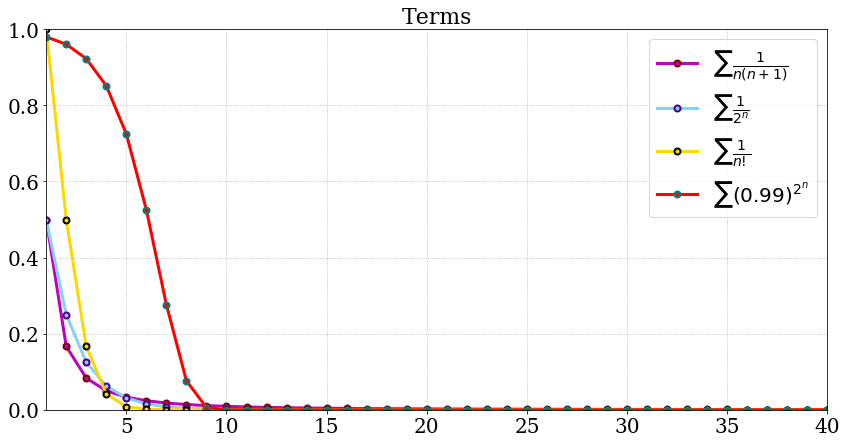

In [8]:
plot(standard_series, 1, 40, 'Terms', y_lims=(0, 1))

We can hardly see anything on this plot. That's why it is **strongly recommended** to use the logarightmic scale for the $y$-axis while dealing with infinitesimal sequences.

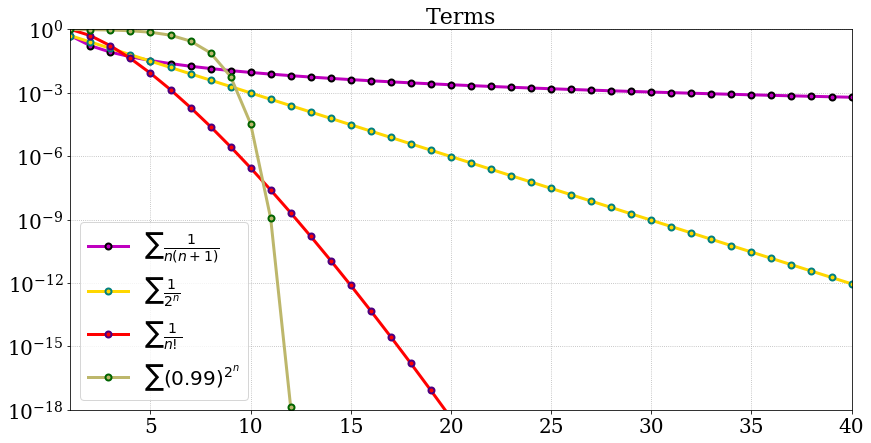

In [9]:
plot(standard_series, 1, 40, 'Terms', semilogy=True, y_lims=(-18, 0))

Here we can see all the different convergence types on this plot.

It's time to plot the partial sums along with sums of the series. The sum of the last series is calculated approximately:

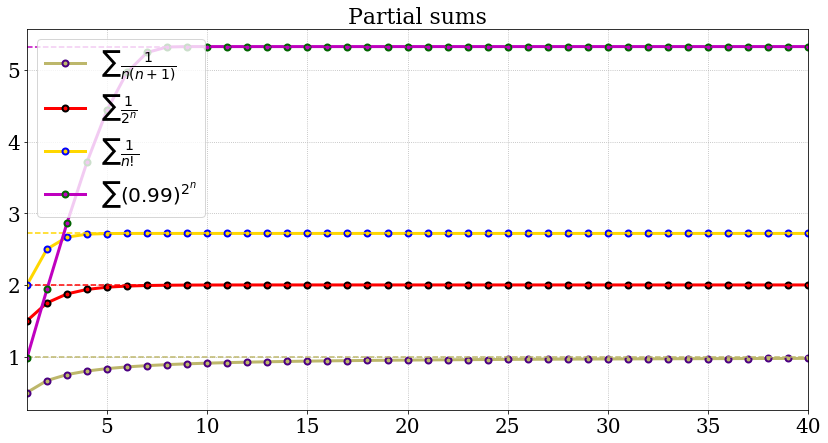

In [10]:
standard_series[-1].estimate_sum(1, 20)
plot(standard_series, 1, 40, 'Partial sums')

Now plot the remainders in semilogy mode:

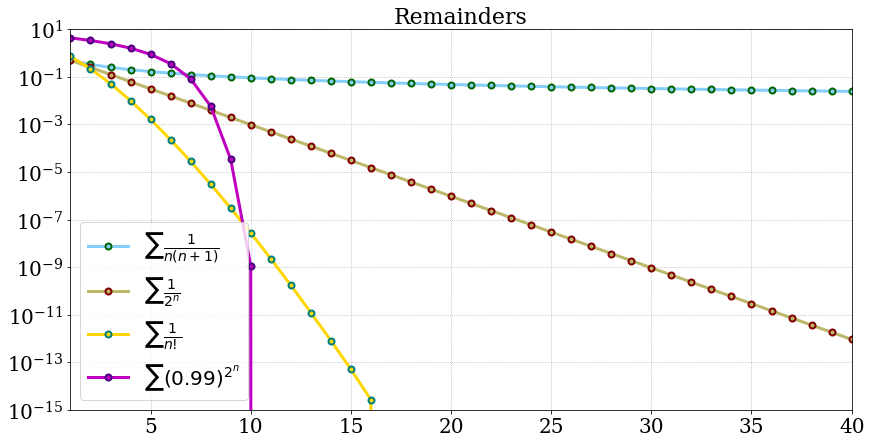

In [11]:
plot(standard_series, 1, 40, 'Remainders', semilogy=True, y_lims=(-15, 1))

Note that for each series the rate of convergence of its terms coincides with that of the remainders.

**The main task here is to do the same things with more complicated series!** Consider the series $\sum\limits_{n=1}^\infty a_n$, $\sum\limits_{n=1}^\infty b_n$, $\sum\limits_{n=1}^\infty c_n$, where

$$
a_n = \sum\limits_{n=1}^\infty \frac{(2n-1)!!}{n^n}, \quad
b_n = \sum\limits_{n=1}^\infty \frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}, \quad
c_n = \sum\limits_{n=1}^\infty \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4.
$$

**(3 points) 1.2.** Determine the rate of convergence to $0$ of the sequences $a_n$, $b_n$, $c_n$ and establish the convergence of each series  $\sum\limits_{n=1}^\infty a_n$, $\sum\limits_{n=1}^\infty b_n$, $\sum\limits_{n=1}^\infty c_n$.

*YOUR SOLUTION HERE* **(photos of handwritten solutions can be submitted as well, but in this case you'll receive at most 2 points!)**

SOLUTIONS:
$$
a_n = \sum\limits_{n=1}^\infty \frac{(2n-1)!!}{n^n}, \quad
$$
Ratio test:
$$
\lim\limits_{n\to\infty} \frac{\frac{(2(n+1) -1)!!}{(n+1)^{n+1}}}{\frac{(2n-1)!!}{n^{n}}} =\\=
\lim\limits_{n\to\infty} \frac{(2n+1)!!}{(2n-1)!!}\cdot \bigg(\frac{n}{n+1}\bigg)^{n}\cdot \frac{1}{n+1}=\lim\limits_{n\to\infty} (2n+1)\cdot \frac{1}{e} \cdot \frac{1}{n+1}= \frac{2}{e} <1 \implies \\ \implies \sum\limits_{n=1}^\infty \frac{(2n-1)!!}{n^n} \ \text{converges.}
\\ \text{As}\ 0< \frac{2}{e}<1 \implies \text{Rate of convergence: Linear convergence.}\\ \quad \\ \quad \\ \quad
$$


$$
b_n = \sum\limits_{n=1}^\infty \frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}
$$
Ratio test:
$$
\quad \\ \lim\limits_{n\to\infty} \frac{\frac{\sqrt{(n+1)^5+(n+1)^3+2}}{(1.2)^{(n+1)^2}}}{\frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}}=\\= \lim\limits_{n\to\infty}\frac{\sqrt{(n+1)^5+(n+1)^3+2}}{(1.2)^{(n+1)^2}}\cdot\frac{(1.2)^{n^2}}{\sqrt{n^5+n^3+2}}=\lim\limits_{n\to\infty}\sqrt{\frac{n^5 + ...}{n^5+...}}\cdot \frac{1}{(1.2)^{2n+1}} = 1\cdot 0 = 0 < 1 \implies \\ \implies \sum\limits_{n=1}^\infty \frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}} \ \text{converges.} \\ \text{As}\ \lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 0 \implies \text{Rate of convergence: Superlinear convergence.}
$$
Quadratic?
Let us calculate the following limit:
$$
\lim\limits_{n\to\infty} \frac{b_{n+1}}{b_n^2}=\\=\lim\limits_{n\to\infty}\frac{\sqrt{(n+1)^5+(n+1)^3+2}}{(1.2)^{(n+1)^2}}\cdot\frac{(1.2)^{n^2}\cdot(1.2)^{n^2}}{n^5+n^3+2}=\lim\limits_{n\to\infty}\sqrt{\frac{n^5 + ...}{n^{10}+...}}\cdot{(1.2)^{n^2-2n-1}} = |  \ \text{as} \ (1.2)^{n^2-2n-1} \ \text{grows faster} \ |= +\infty > 0,\ \implies \ \text{Rate of convergence: Quadratic} \\ \quad \\ \quad \\ \quad
$$


$$
c_n = \sum\limits_{n=1}^\infty \Big(\Big(1+\frac{1}{n}\Big)^{n+1} - e\Big)^4
$$
$$
\text{Consider} \sum\limits_{n=1}^\infty \frac{1}{n^n} \ \text{which is convergent due to root test:} \ \lim\limits_{n\to\infty} \sqrt[n]{\frac{1}{n^n}} =\lim\limits_{n\to\infty} \frac{1}{n} = 0 < 1 \\ \text{Now, let us proceed to limit comparison test}\\ \lim\limits_{n\to\infty} n^n \cdot \bigg(\big(1+\frac{1}{n}\big)^n\big(1+\frac{1}{n}\big)-e\bigg)^4=\lim\limits_{n\to\infty} n^n \cdot \bigg( e \big(\big(1+\frac{1}{n}\big)-1\big)\bigg)^4 = \lim\limits_{n\to\infty} e^4 n^{n-4}= +\infty >0 \implies \\ \implies
\sum\limits_{n=1}^\infty \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4 \ \text{converges.}\\
$$
Rate of convergence?
$$
 \lim\limits_{n\to\infty} \frac{\Big(\Big(1+\frac {1}{n+1}\Big)^{n+2} - e\Big)^4}{\Big(\Big(1+\frac{1}{n}\Big)^{n+1} - e\Big)^4} = \lim\limits_{n\to\infty} \frac{\Big(\Big(1+\frac {1}{n+1}\Big)^{n+1}\Big(1+\frac {1}{n+1}\Big) - e\Big)^4}{\Big(\Big(1+\frac{1}{n}\Big)^{n}\Big(1+\frac {1}{n}\Big) - e\Big)^4} = \lim\limits_{n\to\infty} \frac{\Big(e\Big(1+\frac {1}{n+1}\Big) - e\Big)^4}{\Big(e\Big(1+\frac {1}{n}\Big) - e\Big)^4} = \lim\limits_{n\to\infty} \bigg(\frac{\frac{1}{n+1}}{\frac{1}{n}}\bigg)^4=\\=1^4 = 1 \implies \text{Rate of convergence: Sublinear.}
$$



**(3 points) 1.3.** Plot the sequences $a_n$, $b_n$, $c_n$ on the same picture in semilogy mode. Consider three cases $n_{\max} = 20, 50, 100$, setting the appropriate range for the $y$-axis

In [12]:
from scipy.special import gamma
def double_factorial(t):
    n = (t + 1.)
    n /= 2.
    output = 2.**n * gamma(n + 0.5)/(np.pi**(0.5))
    return output


In [13]:
def a_n(domain):
    n = domain
    a = double_factorial(2*n-1)/np.power(n, n, dtype = np.float64)
    return a

def b_n(domain):
    n = np.float64(domain)
    b = np.float64(np.sqrt(n**5+n**3+2)/(np.power((1.2), (n**2), dtype = np.float64)))
    return b

def c_n(domain):
    n = domain 
    e = np.exp(1)
    c = np.power(((1 + 1/n)**(n+1) - e), 4, dtype = np.float64)
    return c

series_list = [
    Series(r'$\sum{\frac{(2n-1)!!}{n^n}}$', a_n),
    Series(r'$\sum {\frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}}$', b_n),
    Series(r'$\sum {((1+\frac {1}{n})^{n+1} - e)^4}$', c_n)
]


#The following plots are in the three next cells just for better visabilty
# plot(series_list, 1, 20, 'Terms', semilogy=True, y_lims=(-18, 0))
# plot(series_list, 1, 50, 'Terms', semilogy=True, y_lims=(-18, 0))
# plot(series_list, 1, 100, 'Terms', semilogy=True, y_lims=(-18, 0))

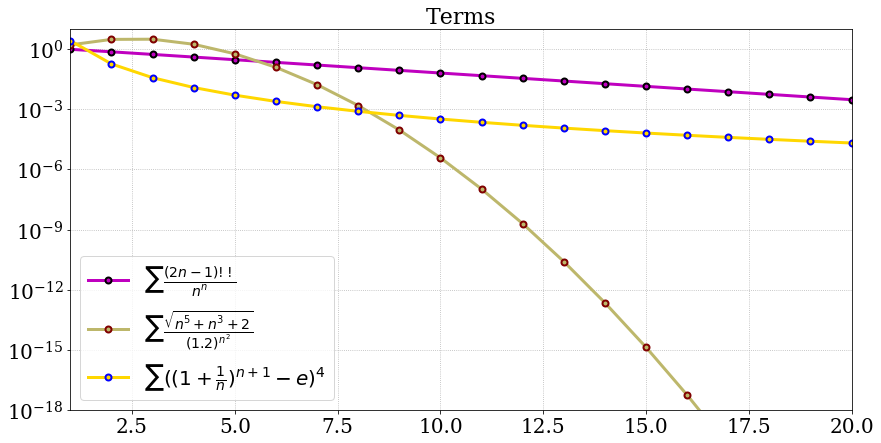

In [14]:
plot(series_list, 1, 20, 'Terms', semilogy=True, y_lims=(-18, 1))

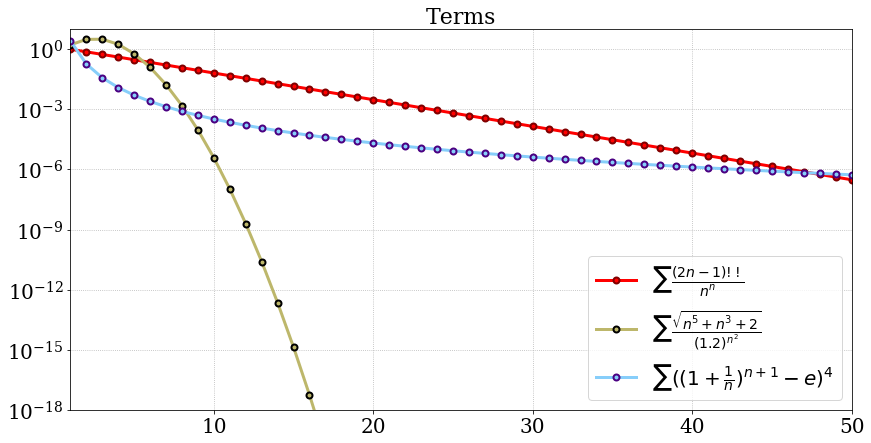

In [15]:
plot(series_list, 1, 50, 'Terms', semilogy=True, y_lims=(-18, 1))

c:\users\den\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in power
  # This is added back by InteractiveShellApp.init_path()


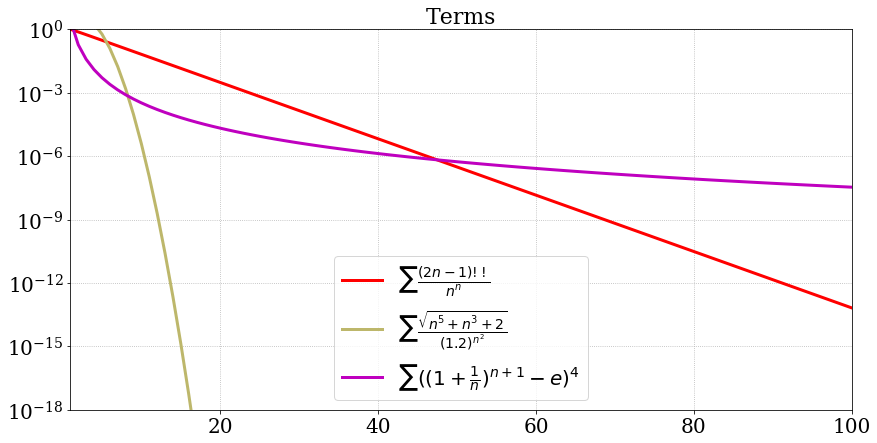

In [16]:
plot(series_list, 1, 100, 'Terms', semilogy=True, y_lims=(-18, 0))

Do this graphs agree with the analytical solution from the previous point?

From the graphs it can be easily seen that the given sequences converge with different pace. Examining the behavior of $a_n$, $b_n$ and $c_n$ which rate of convergence we have obtained analytically, we watch the same picture. It must be noticed that it is very important to check it for bigger n, as the terms can "go" almost parallely for small n, however for greater values of n the rate of convergence of each sequence is more distinguishable.

**(2 points) 1.4.** Calculate approximately the sums of the series with the highest accuracy $\texttt{np.float64}$ would allow you to achieve (relative error should be $\sim 10^{-16}$). 
Try to find the smallest possible partial sums (i. e., the smallest possible $N_a$, $N_b$, $N_c$) appropriate for this goal.

**TIME LIMIT:** 1s.

In [17]:
def part_sum(my_series):
    """Here, we are going to use loop to determine when the accuracy is less then 10^-16"""
    i = 0
    j = 0
    output = 0
    eps = 10**(-16)
    while i - j > eps or i == 0:
        output +=1
        j = i
        i += my_series.term_implementation(output)
    return output

In [18]:
%%time
N_a = part_sum(series_list[0])
N_b = part_sum(series_list[1])
N_c = part_sum(series_list[2])
sum_a = series_list[0].estimate_sum(1, N_a)
sum_b = series_list[1].estimate_sum(1, N_b)
sum_c = series_list[2].estimate_sum(1, N_c)

Wall time: 161 ms


In [19]:
print("Sizes of partial sums: N_a = {}, N_b = {}, N_c = {}".format(N_a, N_b, N_c))

Sizes of partial sums: N_a = 119, N_b = 16, N_c = 11134


In [20]:
print("Sum estimations: S_a = {}, S_b = {}, S_c = {}".format(sum_a, sum_b, sum_c))

Sum estimations: S_a = 3.8627303358663863, S_b = 10.516939669523996, S_c = 2.946989957076794


**(2 points) 1.5.** Plot the partial sums of the given series on the same picture. Consider three cases $n_{\max} = 10, 20, 40$.

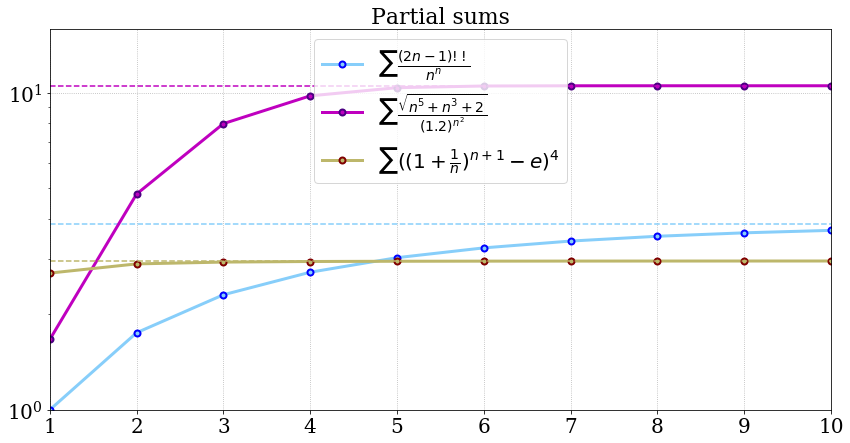

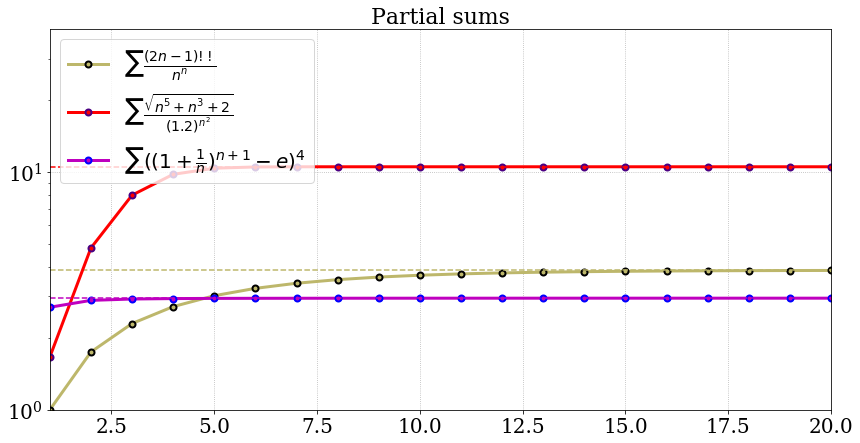

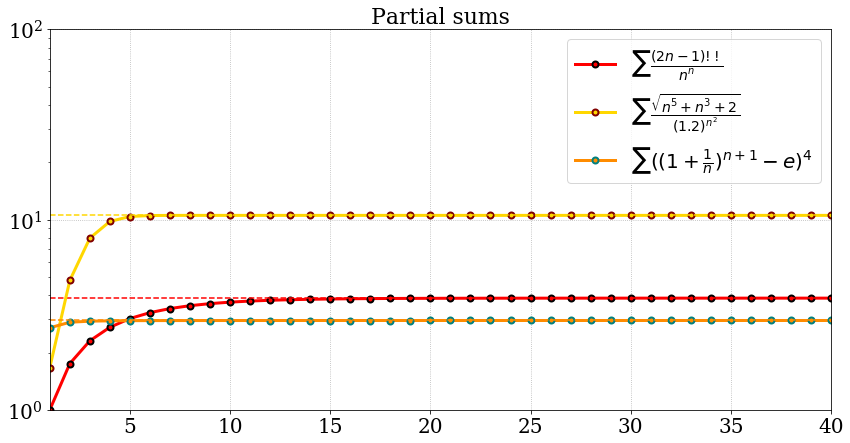

In [21]:
# YOUR CODE HERE
plot(series_list, 1, 10, 'Partial sums', semilogy=True, y_lims=(0, 1.2))
plot(series_list, 1, 20, 'Partial sums', semilogy=True, y_lims=(0, 1.6))
plot(series_list, 1, 40, 'Partial sums', semilogy=True, y_lims=(0, 2))

Looking at these pictures only, can you make any justified conclusions about the rate of convergence of the series?

Indeed, just simple scan of the plots allows us to understand things about the rate of convergence of the sequences given before – earlier the partial sum reaches the corresponding estimation, “sharper” the rate of convergence is. Moreover, all these 3 pictures provides us with a vivid illustration how fast each series convege.

**(2 points) 1.6.** Plot the remainders of the given series on the same picture in the logarithmic scale. Consider three cases $n_{\max} = 25, 50, 100$.

c:\users\den\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in power
  # This is added back by InteractiveShellApp.init_path()


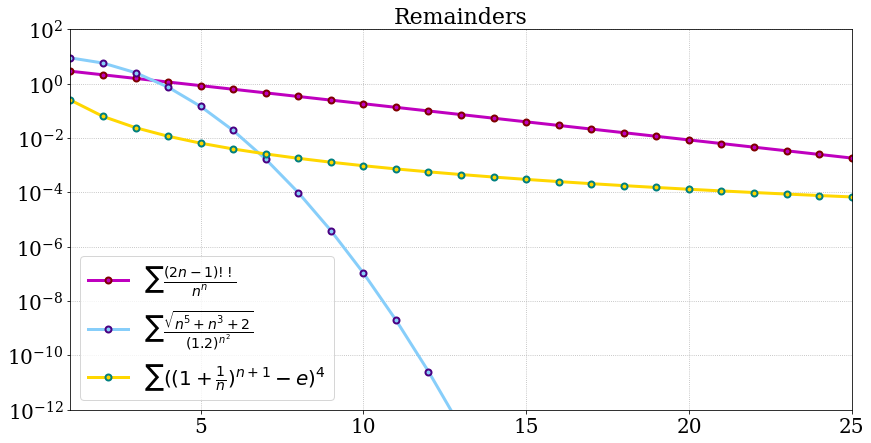

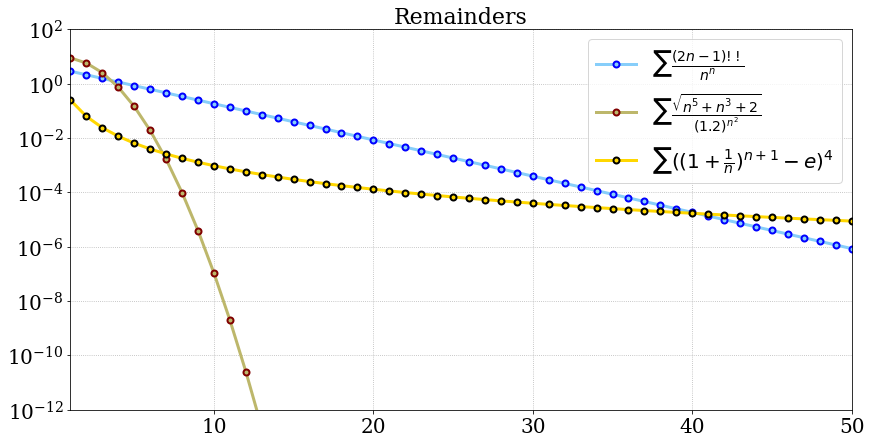

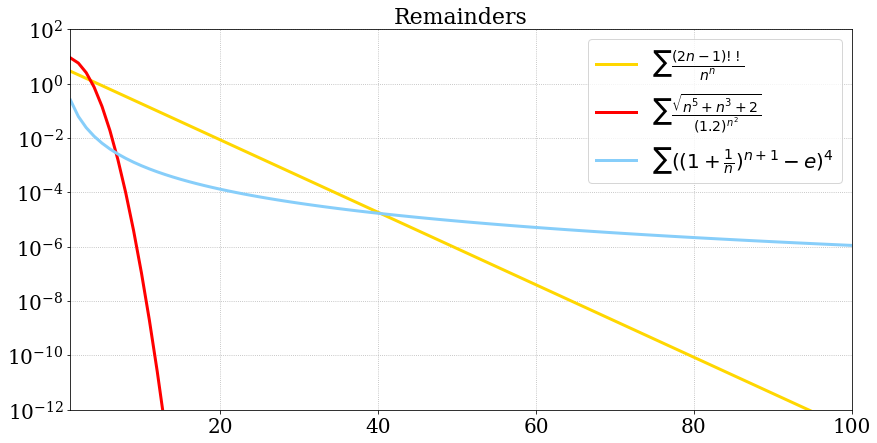

In [22]:
plot(series_list, 1, 25, 'Remainders', semilogy=True, y_lims=(-12, 2))
plot(series_list, 1, 50, 'Remainders', semilogy=True, y_lims=(-12, 2))
plot(series_list, 1, 100, 'Remainders', semilogy=True, y_lims=(-12, 2))

Do the rate of convergence of the remainders coincides with that of terms $a_n$, $b_n$, $c_n$?

As we can see the plots for terms of the series and its remainders are identical. Straightforward comparing of the graphs makes us to say that both terms and remainders of $a_n$, $b_n$ and $c_n$ have the same rate of convergence respectively.

## 2. High precision calculation of $\pi$

Since [Pi](https://en.wikipedia.org/wiki/Pi) is irrational, it can be represented as a nonrepeating decimal fraction. The latest [record](http://www.numberworld.org/digits/Pi/) is more than 31 trillion of calculated digits. We can hardly compete with that, but to achive about $10^5$ true digits of $\pi$ is a relatively easy task. We'll use [Ramanujan's formula](https://en.wikipedia.org/wiki/Ramanujan%E2%80%93Sato_series)
$$
\frac 1\pi = \frac{2\sqrt 2}{9801} \sum\limits_{k=0}^\infty \frac{(4k)! (1103 + 26390k)}{(k!)^4 396^{4k}}
$$

Given $n\in\mathbb N$, we can calculate the partial sum 
$$
S_n =\sum\limits_{k=0}^n \frac{(4k)! (1103 + 26390k)}{(k!)^4 396^{4k}}.
$$

Now $\pi\approx \frac {9801}{2\sqrt 2 S_n}$.

**(4 points) 2.1.** Using the [$\texttt{Decimal}$](https://docs.python.org/3.7/library/decimal.html#module-decimal) module, calculate $\frac 1{S_n}$.

**TIME LIMIT:** 3s if $n \leqslant 1000$.

In [31]:
import math
def calculate_pi(n):
    '''
        n, int : number of terms to sum up
        returns: Decimal object, approximate value of pi
    '''
    COEF = 2
    precision = COEF * n
    context = Context(prec=precision)
    # YOUR CODE HERE
    getcontext().prec = precision
    getcontext().rounding = 'ROUND_DOWN'
    def sn(x):
        return Decimal(math.factorial(4 * x)) * (1103 + 26390 * x) / (396 ** (4 * x)) / Decimal(math.factorial(x) ** 4)
    k = Decimal(9801) / Decimal(2) / Decimal(np.sqrt(Decimal(2)))
    SUM = sum([sn(i) for i in range(0,n+1)])
    pi = Decimal(k) / Decimal(SUM)
    return round(pi, n)

In [32]:
%%timeit
big_pi = calculate_pi(1000)

44.9 s ± 2.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


A verification file containing a billion digits of $\pi$ can be downloaded from [here](https://archive.org/details/Math_Constants).

In [33]:
from os.path import commonprefix

def read_in_chunks(file_object, chunk_size=1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

def check_number(test_number, file_name):    
    i = 0
    chunk_size = 1000
    with open(file_name) as f:
        for piece in read_in_chunks(f, chunk_size):
            common = commonprefix([piece, test_number[i:i + chunk_size]])
            common_len = len(common)
            i += common_len
            if common_len != chunk_size:
                break
    return i - 2

PATH_TO_DIGITS = "Pi - Dec.txt"

def test_big_pi(calc_func=calculate_pi, n_max=2000, size=10,
                path_to_digits=PATH_TO_DIGITS):
    np.random.seed(np.datetime64('now').astype(np.int64))
    random_ns = np.random.randint(1, n_max + 1, size=size)
    for n in random_ns:
        big_pi = calculate_pi(int(n))
        true_digits = check_number(str(big_pi), path_to_digits)
        print("number of terms = {}, true digits = {}, ratio = {}".format(n, true_digits, true_digits / n))

In [34]:
%%time
test_big_pi()

number of terms = 1478, true digits = 1478, ratio = 1.0
number of terms = 1061, true digits = 1061, ratio = 1.0
number of terms = 1909, true digits = 1909, ratio = 1.0
number of terms = 1132, true digits = 1132, ratio = 1.0
number of terms = 416, true digits = 416, ratio = 1.0
number of terms = 1426, true digits = 1426, ratio = 1.0
number of terms = 67, true digits = 67, ratio = 1.0
number of terms = 167, true digits = 167, ratio = 1.0
number of terms = 1684, true digits = 1684, ratio = 1.0
number of terms = 124, true digits = 124, ratio = 1.0
Wall time: 16min 26s


**(2 points) 2.2.** Let $t(n)$ and $d(n)$ be the execution time of your $\texttt{calculate}$_$\texttt{pi}$ function and the number of true digits returned by it respectively. Plot their graphs for $n=10, 20, \ldots, 1000$. What can you say about the asymptotics of $t(n)$ and $d(n)$?

In [35]:
import time
def get_pi_times_and_digits(n_range, func=calculate_pi,  
                            path_to_digits=PATH_TO_DIGITS):
    times = []
    digits = []
    
    # YOUR CODE HERE
    for i in n_range:
        i = int(i)
        start = time.time()
        bp = func(i)
        end = time.time() - start
        times.insert(i//10, end)
        digits.insert(i//10, check_number(str(bp), 'Pi - Dec.txt'))
    
    return times, digits

def plot_pi_list(n_range, pi_list, ylabel):
    plt.figure(figsize=(14,7))
    plt.plot(n_range, pi_list, c='r', lw=2)
    plt.xlim(n_range[0], n_range[-1])
    plt.ylim(0)
    plt.xlabel("n")
    plt.ylabel(ylabel)
    plt.grid(ls=':')

In [36]:
%%time
n_slow = np.arange(10, 1001, 10)
pi_times, pi_digits = get_pi_times_and_digits(n_slow)

Wall time: 19min 29s


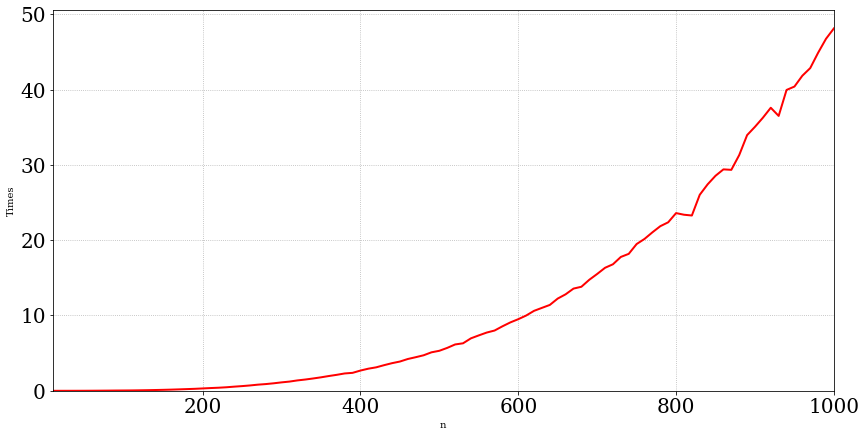

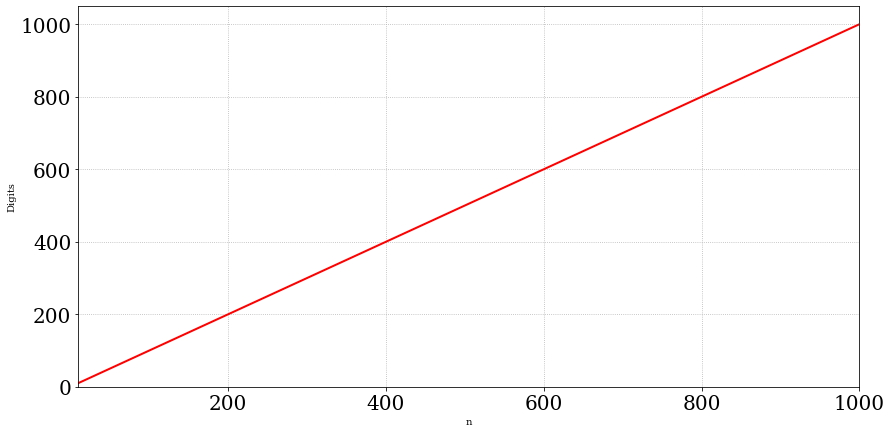

In [37]:
#YOUR CODE HERE
plot_pi_list(n_slow, pi_times, 'Times')
plot_pi_list(n_slow, pi_digits, 'Digits')

**(4 points) 2.3.** Using the Binary splitting technique ([this](http://www.numberworld.org/y-cruncher/internals/binary-splitting.html) and [this](http://www.numberworld.org/y-cruncher/internals/binary-splitting-library.html#pi_ramanujan)), construct a faster algorithm for calculating digits of $\pi$.

**TIME LIMIT:** 10s for $n\leqslant 10^4$.

In [1]:
def calculate_pi_fast(n):
    #YOUR CODE HERE
    COEF =  1
    slice = 7
    precision = COEF * n
    context = Context(prec=precision)
    getcontext().prec = precision + slice
    getcontext().Emax = 999999
    n = Decimal(n)
    def Q(a, b):

        if Decimal(b) - Decimal(a) == 1:
            return Decimal(10939058860032000*b**3)
        else:
            m = Decimal((a+b)//2)
            return Decimal(Q(a,m)*Q(m,b))
        

    def R(a,b):
        if Decimal(b) - Decimal(a) == 1:
            return Decimal((2*b -1)*(6*b-5)*(6*b-1))
        else:
            m = Decimal((a + b) // 2)
            return R(a, m) * R(m, b)

    def P(a, b):
        if Decimal(b) - Decimal(a) == 1:
            return Decimal((13591409+545140134*b)*(2*b-1)*(6*b-5)*(6*b-1)*(-1)**b)
        else:
            m = Decimal((a + b) // 2)
            return Decimal(P(a,m)*Q(m,b)+P(m,b)*R(a,m))

    pi = Decimal(4270934400)*Decimal(Q(0,n))/Decimal(P(0,n)+13591409*Q(0,n))*Decimal(Decimal(1)/np.sqrt(Decimal(10005))) + 0
    return pi

In [39]:
%%timeit
big_pi_fast = calculate_pi_fast(10 ** 4)

4.57 s ± 99.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%time
test_big_pi(calculate_pi_fast, n_max=5000)

number of terms = 4072, true digits = 4072, ratio = 1.0
number of terms = 2363, true digits = 2363, ratio = 1.0
number of terms = 2401, true digits = 2401, ratio = 1.0
number of terms = 39, true digits = 39, ratio = 1.0
number of terms = 3548, true digits = 3548, ratio = 1.0
number of terms = 4314, true digits = 4314, ratio = 1.0
number of terms = 1038, true digits = 1038, ratio = 1.0
number of terms = 206, true digits = 206, ratio = 1.0
number of terms = 4625, true digits = 4625, ratio = 1.0
number of terms = 916, true digits = 916, ratio = 1.0
Wall time: 3h 58min 49s


**(3 points) 2.4.** Let $t_f(N)$ and $d_f(N)$ be the execution time of your $\texttt{calculate}$_$\texttt{pi}$_$\texttt{fast}$ function. Plot the graph of $t_f(N)$ and $d_f(N)$ for $N=10, 20, \ldots, 2000$. Also plot both graphs of $t(N)$ and $t_f(N)$ on the same picture. What can you say about the asymptotics of $t_f(N)$?

In [41]:
%%time
n_fast = np.arange(10, 2001, 10)
pi_times_fast, pi_digits_fast = get_pi_times_and_digits(n_fast, func=calculate_pi_fast)

Wall time: 40.8 s


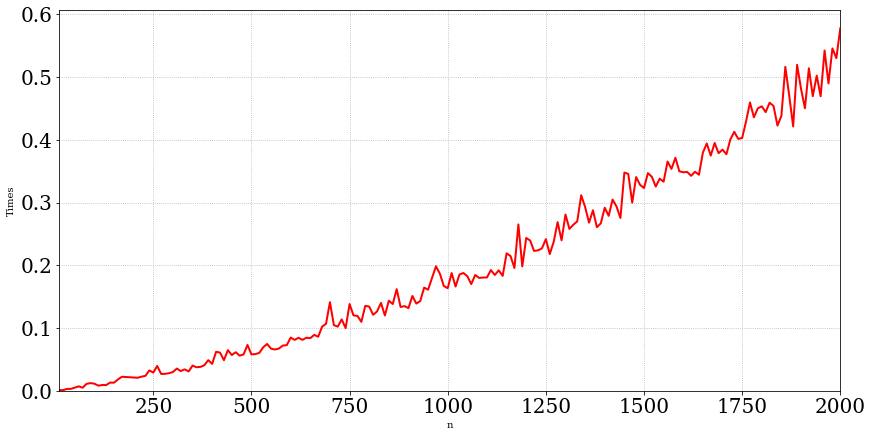

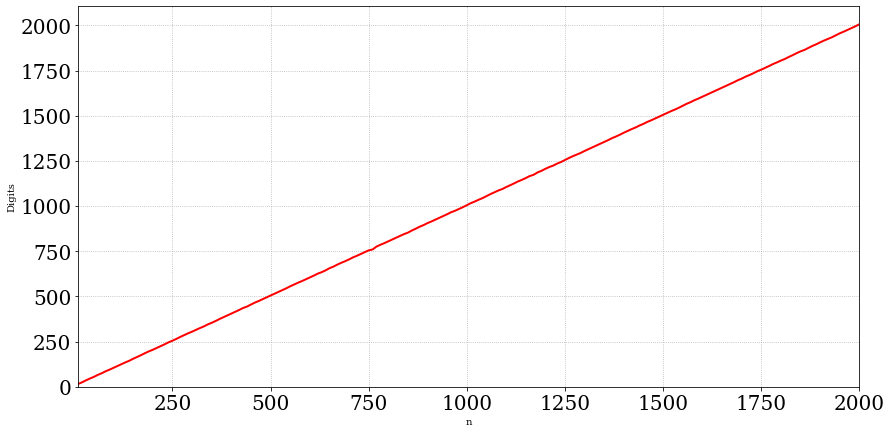

In [42]:
#YOUR CODE HERE
plot_pi_list(n_fast, pi_times_fast, 'Times')
plot_pi_list(n_fast, pi_digits_fast, 'Digits')

In [43]:
def plot_pi_times_both(range_list, times_list, labels):
    plt.figure(figsize=(14,7))
    colors = ['r', 'b', 'm', 'c']
    N_max = 0
    for i, times in enumerate(times_list):
        N = range_list[i][-1]
        N_max = max(N_max, N)
        plt.plot(range_list[i], times, c=colors[i], lw=2, label=labels[i])
    plt.xlim(1, N_max)
    plt.ylim(0)
    plt.xlabel("n")
    plt.ylabel("time, s")
    plt.grid()
    plt.legend();

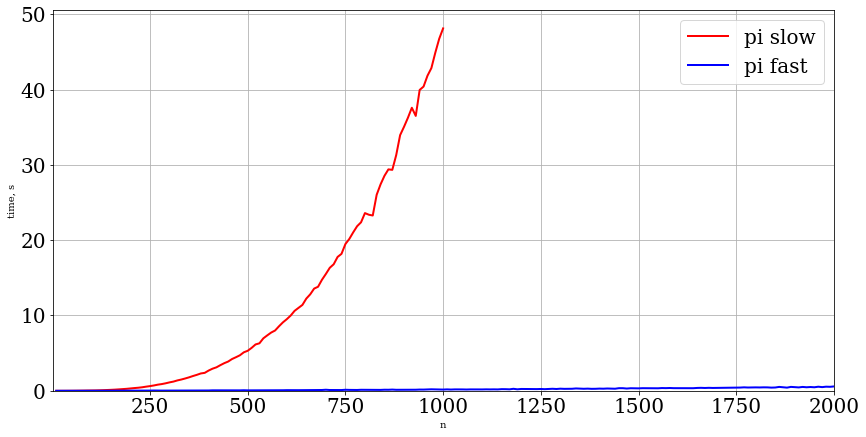

In [45]:
# YOUR CODE HERE
plot_pi_times_both([n_slow, n_fast],[pi_times,pi_times_fast], ["pi slow", "pi fast"])

**(1 point) 2.5**. Now it's time to calculate $200$ thousands digits of $\pi$:

**TIME LIMIT.** 3m.

In [ ]:
%%time
big_pi = calculate_pi_fast(20000)
true_digits = check_number(str(big_pi), 'Pi - Dec.txt')
print("{} true digits of pi were calculated!".format(true_digits))